In this project we'll train agents that choose to run, pass, kick or punt based on the current yards to first, yards to goal, and down.

First we need to create a stable baselines3 compliant custom environment (SB3's guide - https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html).

In [3]:
import numpy as np
from numpy import random
from scipy import stats
import gymnasium as gym
from gymnasium import spaces

# the function provides the other team's expected points when there is a change of possession.
def calc_ep(ydsToGo, ydsToGo_ep_intercept=5.211187389603027, ydsToGo_coef=-0.06155063):
    return ydsToGo_ep_intercept + ydsToGo * ydsToGo_coef

touchback_ep = calc_ep(80)

def normalize_continuous(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

class NflEnv(gym.Env):
    
    def __init__(self, init_yds_to_goal = 80):
        super(NflEnv, self).__init__()

        self.action_space = spaces.Discrete(4)  # 0 - run, 1 - pass, 2 - kick, 3 - punt

        
        self.observation_space = spaces.Dict({
            "yds_to_goal": spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
            "yds_to_first": spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
            "down": spaces.Discrete(4)
        })

        
        # self.init_yds_to_goal = init_yds_to_goal
        self.yds_to_goal = random.triangular(1, 80, 99)
        self.init_down = 0
        self.init_yds_to_first = 10
        
        self.comp_percent=.642
        self.int_rate=.023
        self.sack_rate=.067
        self.sack_avg=-5
        self.sack_sd=1
        self.fmb_rate=.5 / (21.4 + 27.3)

    def step(self, action):
        
        prev_down = self.down
        prev_yds_to_first = self.yds_to_first
        prev_yds_to_goal = self.yds_to_goal
        
        self.down += 1
        score = 0
        yds = 0
        turnover = False

        # kick
        if action == 2:
            prob = random.rand()
            # made fg
            # https://www.reddit.com/r/nfl/comments/d4h2r0/kicker_accuracy_accounting_for_distance/
            if ((self.yds_to_goal < 60) & (self.yds_to_goal >= 50) & (prob <= .54)) \
                    | ((self.yds_to_goal < 50) & (self.yds_to_goal >= 40) & (prob <= .79)) \
                    | ((self.yds_to_goal < 40) & (self.yds_to_goal >= 30) & (prob <= .90)) \
                    | ((self.yds_to_goal < 30) & (prob <= .95)):
                yds = self.yds_to_goal
                self.yds_to_goal = 0
                self.yds_to_first = 0
                score = 3
                self.reward = score - touchback_ep
            # missed fg
            else:
                score = 0
                self.reward = score - calc_ep(100 - self.yds_to_goal)
            self.done = True
        # punt
        elif action == 3:  
            potential_yds = random.normal(loc=45, scale=5)
            if potential_yds >= self.yds_to_goal:
                touchback = (np.random.rand() < 0.1)
                if touchback:
                    yds = self.yds_to_goal - 20
                    self.yds_to_goal = 20
                else:
                    yds = self.yds_to_goal - 1
                    self.yds_to_goal = 1
            else:
                yds = potential_yds
                self.yds_to_goal = self.yds_to_goal - yds
    
            self.reward += ((yds / 100) - calc_ep(100 - self.yds_to_goal))
            self.done = True

        # run
        elif action == 0:
            yds = stats.lognorm.rvs(s=0.25558500132474415, loc=-15.189614313924665, scale=18.92331909863129, size=1)[0]
            # fumble?
            if np.random.rand() <= self.fmb_rate:
                turnover = True
        # pass
        elif action == 1:
            # sack?
            if np.random.rand() <= self.sack_rate:
                yds = random.normal(loc=self.sack_avg, scale=self.sack_sd)
                # fumble?
                if np.random.rand() <= self.fmb_rate:
                    turnover = True
            else:
                if self.yds_to_goal <= 20:
                    air_yds = \
                        stats.lognorm.rvs(s=0.18033921317690882, loc=-20.781271075327744, scale=27.083791999969066, size=1)[0]
                else:
                    air_yds = \
                        stats.lognorm.rvs(s=0.3868256330626365, loc=-11.72666357691477, scale=21.714746429166233, size=1)[0]
                prob = np.random.rand()
                # completion?
                if prob <= self.comp_percent:
                    yds = air_yds
                    # fumble?
                    if np.random.rand() <= self.fmb_rate:
                        yds = air_yds
                        turnover = True
                # int?
                elif prob >= (1 - self.int_rate):
                    yds = air_yds
                    turnover = True
                # incomplete
                else:
                    yds = 0
        # if action is not kick or punt
        if action in [0, 1]:
            self.yds_to_goal = max(self.yds_to_goal - yds, 0)
            self.yds_to_first -= yds
            # first down?
            if self.yds_to_first <= 0:
                self.down = self.init_down
                self.yds_to_first = min(self.yds_to_goal, self.init_yds_to_first)
            # turnover on downs?
            elif self.down >= (self.init_down + 4):
                turnover = True
            # td?
            if self.yds_to_goal == 0:
                score = 7
                self.reward = score - touchback_ep
                self.done = True
            if turnover == True:
                score = 0
                # should take touchback into account
                self.reward = score - calc_ep(100 - self.yds_to_goal)
                self.done = True
            # trying a shaping reward here. just kind of winging this, probably needs refined
            self.reward += (yds / 100)
        
        # not sure this is right but I think 5th down (expressed as 4) is breaking things turnover, kick on fourth down 
        if (self.down == (self.init_down + 4)):
            self.down = self.init_down

        self.state = {
            "yds_to_goal": np.array([self.yds_to_goal], dtype=np.float32),
            "yds_to_first": np.array([self.yds_to_first], dtype=np.float32),
            "down": self.down  # Represents value 3 (0: 1st down, 1: 2nd down, 2: 3rd down, 3: 4th down)
        }
        
        self.episode_reward += self.reward
        
        info = {}
        info.update({
            'prev_down': prev_down,
            'prev_yds_to_first': prev_yds_to_first,
            'prev_yds_to_goal': prev_yds_to_goal,
            'yds': yds,
            'turnover': turnover,
            'score': score
        })
        
        # https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py
        return self.state, self.reward, self.done, False, info

    def reset(self, seed=None, yds_to_goal=None):

        # https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self.down = self.init_down
        self.yds_to_first = self.init_yds_to_first
        if yds_to_goal is not None:
            self.yds_to_goal = yds_to_goal
        else:
            self.yds_to_goal = random.triangular(1, 80, 99)
        
        self.state = {
            "yds_to_goal": np.array([self.yds_to_goal], dtype=np.float32),
            "yds_to_first": np.array([self.yds_to_first], dtype=np.float32),
            "down": self.down  # Represents value 3 (0: 1st down, 1: 2nd down, 2: 3rd down, 3: 4th down)
        }
        
        self.reward = 0
        self.episode_reward = 0
        self.done = False
        
        # https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py
        info = {}
        return self.state, info
    

    
    def set_yds_to_goal(self, yds_to_goal):
        self.yds_to_goal = yds_to_goal
        self.state = {
            "yds_to_goal": self.yds_to_goal
            , "yds_to_first": self.yds_to_first
            , "down": self.down}
        
        return self.state
        
    
    def pretty_print(self, state, action, info):
        down = state["down"]
        yds_to_first = state["yds_to_first"][0]
        yds_to_goal = state["yds_to_goal"][0]
        
        yds = info["yds"]
        turnover = info["turnover"]
        score = info["score"]
        prev_down = info["prev_down"]
        prev_yds_to_first = info["prev_yds_to_first"]
        prev_yds_to_goal = info["prev_yds_to_goal"]

        if action == 0:
            action = "Run"
        elif action == 1:
            action = "Pass"
        elif action == 2:
            action = "Kick"
        elif action == 3:
            action = "Punt"
        
        print(f"Down: {prev_down}, Yards to First: {prev_yds_to_first:.1f}, Yards to Goal: {prev_yds_to_goal:.1f}, Action: {action}, Yards Gained: {yds:.1f}, Turnover: {turnover}")
        if turnover: print('Turnover')
        if action == 'Kick':
            if score == 3:
                print('Made Field Goal')
            else:
                print('Missed Field Goal')
        if score == 7: print('Touchdown')
            
        return

Before we train the agents let's first try a custom policy on the environment. We'll use this as a benchmark to see how well the agents learn. Further, let's create two styles (chill & agro) so we can watch them play against each other. We'll want that functionality when we have the agents.

In [4]:
from random import choices

def custom_policy(state, style = 'chill'):
    down = state['down']
    yds_to_first = state['yds_to_first']
    yds_to_goal = state['yds_to_goal']

    if down == 0:
        if style == 'chill':
            # run first team
            return choices([0, 1], weights=[70, 30], k=1)[0]
        elif style == 'agro':
            # pass first team
            return choices([0, 1], weights=[30, 70], k=1)[0]
        
    if down == 1:
        # heavy run first if ahead of the sticks
        if yds_to_first <= (2*10/3):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # else pass first
        else:
            return choices([0, 1], weights=[30, 70], k=1)[0]
        
    if down == 2:
        # passing down if well behind the sticks
        if yds_to_first >= (2*10/3):
            return 1
        # heavy run first if ahead of the sticks
        elif yds_to_first <= (10/3):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # else (>3.33 and <6.67) pass first
        else:
            return choices([0, 1], weights=[30, 70], k=1)[0]

    # Kick on fourth down if yards to goal is less than 60 yards else same logic as third down
    if down == 3:
        # agro will always go for it ahead of the sticks
        if (style == 'agro') & (yds_to_first <= (10/3)):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # kick
        elif yds_to_goal < 60:
            return 2
        # punt
        else:
            return 3

def custom_policy(state, style = 'chill'):
    down = state['down']
    yds_to_first = state['yds_to_first']
    yds_to_goal = state['yds_to_goal']

    if down == 0:
        if style == 'chill':
            # run first team
            return choices([0, 1], weights=[70, 30], k=1)[0]
        elif style == 'agro':
            # pass first team
            return choices([0, 1], weights=[30, 70], k=1)[0]
        
    if down == 1:
        # heavy run first if ahead of the sticks
        if yds_to_first <= (2*10/3):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # else pass first
        else:
            return choices([0, 1], weights=[30, 70], k=1)[0]
        
    if down == 2:
        # passing down if well behind the sticks
        if yds_to_first >= (2*10/3):
            return 1
        # heavy run first if ahead of the sticks
        elif yds_to_first <= (10/3):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # else (>3.33 and <6.67) pass first
        else:
            return choices([0, 1], weights=[30, 70], k=1)[0]

    # Kick on fourth down if yards to goal is less than 60 yards else same logic as third down
    if down == 3:
        # agro will always go for it ahead of the sticks
        if (style == 'agro') & (yds_to_first <= (10/3)):
            return choices([0, 1], weights=[85, 15], k=1)[0]
        # kick
        elif yds_to_goal < 60:
            return 2
        # punt
        else:
            return 3


def evaluate_custom_policy(env, style='chill', n_episodes=1000, watch=False):
    rewards = []
    
    for episode in range(n_episodes):
        state, info = env.reset()
        done = False
        episode_reward = 0
        step_count = 0

        while not done:
            action = custom_policy(state)
            state, reward, done, placeholder, info = env.step(np.array([action]))
            episode_reward += reward

            if watch and episode == n_episodes - 1:
                yds = info['yds']
                prev_down = info['prev_down']
                prev_yds_to_first = info['prev_yds_to_first']
                prev_yds_to_goal = info['prev_yds_to_goal']
                turnover = info['turnover']
                print(f"Step: {step_count}, Dwn: {prev_down}, to First: {round(float(prev_yds_to_first), 2)}, to Goal: {round(float(prev_yds_to_goal), 2)}, Action: {action}, Yds Gained: {round(float(yds), 2)}, Reward: {round(float(reward), 2)}, Tot Reward: {round(float(episode_reward), 2)}, TO: {turnover}")

            step_count += 1
        
        rewards.append(episode_reward)

    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)

    return mean_reward, std_reward

n_eval_episodes = 1_000
styles = ['chill', 'agro']
for style in styles:
    env = NflEnv()
    mean_reward_custom, std_reward_custom = evaluate_custom_policy(env, style, n_episodes=n_eval_episodes, watch=False)
    print(f"{style} Custom policy mean reward: {mean_reward_custom:.2f} +/- {std_reward_custom:.2f}")

chill Custom policy mean reward: 3.64 +/- 3.68
agro Custom policy mean reward: 3.51 +/- 3.70


Let's watch the two styles play a game against each other, first with text and then with images.

In [5]:
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

def draw_field(player_with_ball, starting_yds_to_goal, yds, drive_yds, player_1_score, player_2_score, one_image='n'):
    plt.figure(figsize=(20, 5))
    plt.barh(0, 100, color='green', height=5)
    plt.xlim(0, 100)
    plt.ylim(-1, 1)
    plt.xticks(range(0, 101, 10))
    plt.yticks([])
    plt.grid(axis='x')

    if player_with_ball == 1:
        starting_ball_position = (100 - starting_yds_to_goal)
        ball_position = starting_ball_position + drive_yds
    elif player_with_ball == 2:
        starting_ball_position = starting_yds_to_goal
        ball_position = starting_ball_position - drive_yds
    
    # Plot the ball
    plt.plot(ball_position, 0, 'o', markersize=20, color='orange')

    plt.text(ball_position, 0.1, f'Play gain: {yds} yards\nTotal drive: {drive_yds} yards',
             horizontalalignment='center', verticalalignment='bottom', color='white', fontsize=12, fontweight='bold')

    if player_with_ball == 1:
        plt.barh(0, drive_yds, left=starting_ball_position, color='red', height=0.1)
    else:  # team 2
        plt.barh(0, drive_yds, left=ball_position, color='blue', height=0.1)
    
    # Add a scoreboard in the top right corner
    plt.text(98, 0.8, f'Team 1: {player_1_score}\nTeam 2: {player_2_score}', 
             horizontalalignment='right', verticalalignment='top', 
             bbox=dict(boxstyle="square,pad=1", fc="white", ec="black"), fontsize=14)
    
    if one_image == 'n':
        plt.show()
    else:
        clear_output(wait=True)  # This will clear the output before showing the new plot
        display(plt.gcf())  # This will display the current plot
        plt.close()  # This will close the plot so it doesn't get shown again later
        time.sleep(0.25)  # wait for quarter second between plays
        


def play_game(env, possessions=2, style_1='chill', style_2='agro', model_1=None, model_2=None, players = [1, 2], text_viz='y', image_viz='n', one_image='n'):
    
    starting_yds_to_goal = 80
    player_1_score = 0
    player_2_score = 0
    
    if model_1 is not None:
        print('player 1 is an agent')
    else:
        print(f'player 1 is using {style_1} play style')
    if model_2 is not None:
        print('player 2 is an agent')
    else:
        print(f'player 2 is using {style_2} play style')
    print()

    for possessions in range(1, possessions+1):

        for player in players:
            
            if text_viz == 'y':
                if player == 1:
                    print(f"player 1 taking possession with {starting_yds_to_goal:.2f} yards to go")
                else:
                    print(f"player 2 taking possession with {starting_yds_to_goal:.2f} yards to go")
            
            # state = env.reset(yds_to_goal = starting_yds_to_goal)
            state, info = env.reset(yds_to_goal = starting_yds_to_goal)
            
            done = False
            episode_reward = 0
            
            drive_yds = 0

            while not done:
                state_array = {'yds_to_goal': np.array([state['yds_to_goal']]), 'yds_to_first': np.array([state['yds_to_first']]), 'down': np.array([state['down']])}
                if player == 1:
                    if model_1 is not None:
                        action, _states = model_1.predict(state_array)
                    else:
                        action = custom_policy(state, style=style_1)
                elif player == 2:
                    if model_2 is not None:
                        action, _states = model_2.predict(state_array)
                    else:
                        action = custom_policy(state, style=style_2)
                state, reward, done, placeholder, info = env.step(np.array([action]))
                episode_reward += reward
                
                score = info["score"]                
                if player == 1:
                    player_1_score += score
                else:
                    player_2_score += score
                
                if text_viz == 'y':
                    env.pretty_print(state, action, info)
                    
                if image_viz == 'y':
                    yds = info["yds"]
                    drive_yds += yds
                    draw_field(player_with_ball=player, starting_yds_to_goal=round(starting_yds_to_goal,1), yds=round(yds,1), drive_yds=round(drive_yds,1), player_1_score=player_1_score, player_2_score=player_2_score, one_image=one_image)
                                
            # if not made fg or td, probably better way to implement. This doesn't include punt touchbacks.
            if score < 3:
                starting_yds_to_goal = 100 - state["yds_to_goal"][0]
            else:
                starting_yds_to_goal = 80
            
            if text_viz == 'y':
                print('Scoreboard:')
                print(f"player 1 - {player_1_score}")
                print(f"player 2 - {player_2_score}")
                print()

In [6]:
play_game(env=NflEnv())

player 1 is using chill play style
player 2 is using agro play style

player 1 taking possession with 80.00 yards to go
Down: 0, Yards to First: 10.0, Yards to Goal: 80.0, Action: Run, Yards Gained: 3.6, Turnover: False
Down: 1, Yards to First: 6.4, Yards to Goal: 76.4, Action: Run, Yards Gained: 3.9, Turnover: False
Down: 2, Yards to First: 2.5, Yards to Goal: 72.5, Action: Run, Yards Gained: -2.6, Turnover: False
Down: 3, Yards to First: 5.2, Yards to Goal: 75.2, Action: Punt, Yards Gained: 35.9, Turnover: False
Scoreboard:
player 1 - 0
player 2 - 0

player 2 taking possession with 60.71 yards to go
Down: 0, Yards to First: 10.0, Yards to Goal: 60.7, Action: Run, Yards Gained: 5.0, Turnover: False
Down: 1, Yards to First: 5.0, Yards to Goal: 55.7, Action: Run, Yards Gained: 4.1, Turnover: False
Down: 2, Yards to First: 0.9, Yards to Goal: 51.6, Action: Run, Yards Gained: 13.3, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 38.3, Action: Run, Yards Gained: 1.1, Turnover

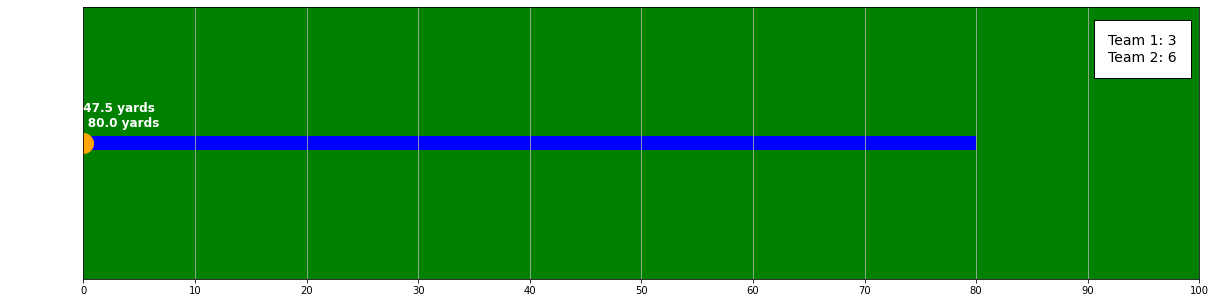

In [7]:
# play_game(env=NflEnv(), text_viz='n', image_viz='y')
play_game(env=NflEnv(), text_viz='n', image_viz='y', one_image='y')

Now for the fun part, let's use RL to train agents. We'll use stable baselines3 to train and weights & biases to monitor and evaluate our training runs. First, let's import libraries and set hyperparameters.

In [8]:
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# uncomment when SB3 & wandb are working together again
# import wandb
# from wandb.integration.sb3 import WandbCallback
# wandb.login()

let's first make sure our custom environment will work with SB3.

In [9]:
def run_training_job(model_type
                    , use_wandb = 'y', wandb_verbose=2
                    , timesteps=1_000_000
                    , policy='MultiInputPolicy'
                    # needs to be a decent number given starting position is random
                    , n_eval_episodes=1_000
                    , vec_envs='n', n_envs=4
                    , sb3_model_verbose=0
                    # DQN
                    , dqn_exploration_final_eps=0.025, dqn_exploration_fraction=0.5
                    # PPO
                    # https://colab.research.google.com/drive/1GI0WpThwRHbl-Fu2RHfczq6dci5GBDVE#scrollTo=FMdJRrZ4n7xp
                    , ppo_n_steps = 1024, ppo_batch_size = 64, ppo_n_epochs = 4, ppo_gamma = 0.999, ppo_gae_lambda = 0.98, ppo_ent_coef = 0.01,
                    ):
    
    config = {
    "policy_type": policy,
    "total_timesteps": timesteps,
    "env_id": "NflEnv",
    }

    # https://stable-baselines3.readthedocs.io/en/master/guide/integrations.html
    if use_wandb == 'y':
        run = wandb.init(
            project="sb3_nfl_2",
            config=config,
            sync_tensorboard=True
        )

    # when using multiple environments, the total number of steps taken in counts each step taken in each environment
    # if using 4 environments and 400_000 TIMESTEPS, the agent will take a total of 100_000 steps in each environment.
    if vec_envs == 'y':
        # https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb
        # received 'ValueError: high is out of bounds for int32' without the seed
        env = make_vec_env(env_id = NflEnv, n_envs=n_envs, seed=1)
        eval_env = make_vec_env(env_id = NflEnv, n_envs=1, seed=1)

    elif vec_envs == 'n':
        env = NflEnv()
        eval_env = NflEnv()
    
    if use_wandb == 'y':
        if model_type == 'DQN':
            # default values for these parameters are exploration_final_eps=0.05 and exploration_fraction=0.1
            # with the default values, the exploration rate will linearly decrease to 0.05 over the first 10% of the timesteps
            model = DQN(config["policy_type"], env, verbose=sb3_model_verbose, tensorboard_log=f"runs/{run.id}"
                        , exploration_final_eps=dqn_exploration_final_eps, exploration_fraction = dqn_exploration_fraction)
        elif model_type == 'PPO':
            model = PPO(config["policy_type"], env, verbose=sb3_model_verbose, tensorboard_log=f"runs/{run.id}"
                        , n_steps = ppo_n_steps, batch_size = ppo_batch_size, n_epochs = ppo_n_epochs, gamma = ppo_gamma
                        , gae_lambda = ppo_gae_lambda, ent_coef = ppo_ent_coef)
        elif model_type == 'A2C':
            model = A2C(config["policy_type"], env, verbose=sb3_model_verbose, tensorboard_log=f"runs/{run.id}")
    else:
        if model_type == 'DQN':
            model = DQN(config["policy_type"], env, verbose=sb3_model_verbose, exploration_final_eps=dqn_exploration_final_eps
                        , exploration_fraction = dqn_exploration_fraction)
        elif model_type == 'PPO':
            model = PPO(config["policy_type"], env, verbose=sb3_model_verbose
                        , n_steps = ppo_n_steps, batch_size = ppo_batch_size, n_epochs = ppo_n_epochs, gamma = ppo_gamma
                        , gae_lambda = ppo_gae_lambda, ent_coef = ppo_ent_coef)
        elif model_type == 'A2C':
            model = A2C(config["policy_type"], env, verbose=sb3_model_verbose)

    mean_reward, std_reward = evaluate_policy(model=model, env=eval_env, n_eval_episodes=n_eval_episodes)
    print(f"mean_reward before training:{mean_reward:.2f} +/- {std_reward:.2f}")

    if use_wandb == 'y':
        model.learn(
            total_timesteps=config["total_timesteps"],
            callback=WandbCallback(
                model_save_path=f"models/{run.id}",
                verbose=wandb_verbose,
            ),
        )
        run.finish()
    else:
        model.learn(total_timesteps=config["total_timesteps"])

    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=n_eval_episodes)
    print(f"mean_reward after training:{mean_reward:.2f} +/- {std_reward:.2f}")

    # parameters_saved = model.get_parameters()
    
    if vec_envs == 'y':
        model.save(f"models/{model_type}_{timesteps}_vecEnv")
    else:
        model.save(f"models/{model_type}_{timesteps}")
    
    return model

NOTE: as of 7/21/23 there appears to be issue between SB3 and wandb. Need to root cause and fix to enable using wandb during training.
use this setup for debugging - https://stable-baselines3.readthedocs.io/en/master/guide/integrations.html

In [8]:
dqn_model = run_training_job('DQN',timesteps=1_000_000, use_wandb='n')

c:\Users\grant\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward before training:2.66 +/- 4.99
mean_reward after training:3.94 +/- 4.56


Let's watch DQN and PPO play eachother

In [10]:
ppo_model = run_training_job('PPO',timesteps=1_000_000, use_wandb='n')

c:\Users\grant\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward before training:0.93 +/- 2.77
mean_reward after training:3.77 +/- 4.99


In [10]:
ppo_model = PPO.load('models/PPO_1000000')
dqn_model = DQN.load('models/DQN_1000000')
play_game(env=NflEnv(), model_1=ppo_model, model_2=dqn_model, possessions=3)

player 1 is an agent
player 2 is an agent

player 1 taking possession with 80.00 yards to go
Down: 0, Yards to First: 10.0, Yards to Goal: 80.0, Action: Pass, Yards Gained: 13.5, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 66.5, Action: Pass, Yards Gained: -5.2, Turnover: False
Down: 1, Yards to First: 15.2, Yards to Goal: 71.7, Action: Pass, Yards Gained: 0.4, Turnover: False
Down: 2, Yards to First: 14.8, Yards to Goal: 71.3, Action: Pass, Yards Gained: 9.7, Turnover: False
Down: 3, Yards to First: 5.0, Yards to Goal: 61.6, Action: Pass, Yards Gained: 0.0, Turnover: True
Turnover
Scoreboard:
player 1 - 0
player 2 - 0

player 2 taking possession with 38.43 yards to go
Down: 0, Yards to First: 10.0, Yards to Goal: 38.4, Action: Run, Yards Gained: 9.1, Turnover: False
Down: 1, Yards to First: 0.9, Yards to Goal: 29.3, Action: Pass, Yards Gained: 53.5, Turnover: False
Touchdown
Scoreboard:
player 1 - 0
player 2 - 7

player 1 taking possession with 80.00 yards to go
Down

let's see if vectorized environments with more steps improve performance

In [15]:
n_envs = 32
timesteps=1_000_000 * n_envs
model_type = 'PPO'
model = run_training_job(model_type=model_type,timesteps=timesteps, vec_envs='y', n_envs=n_envs, use_wandb='n')

{model_type}
mean_reward before training:-1.33 +/- 3.04
mean_reward after training:4.37 +/- 4.46


In [13]:
import pandas as pd

def evaluate_play_style(model, env, num_episodes=1_000):
    env = NflEnv()

    # Define the columns
    columns = ['Game_ID', 'Play_ID', 'yds_to_goal', 'yds_to_first', 'down', 'action', 'reward', 'done', 'new_yds_to_goal', 'new_yds_to_first', 'new_down']

    # Initialize the lists
    data = {col: [] for col in columns}
    
    
    # Training loop
    for i_episode in range(num_episodes):
        
        state, info = env.reset()
        play_id = 0
        
        done = False
        
        while True:
            state_array = {'yds_to_goal': np.array([state['yds_to_goal']]), 'yds_to_first': np.array([state['yds_to_first']]), 'down': np.array([state['down']])}
            
            action, _states = model.predict(state_array)
            new_state, reward, done, placeholder, info = env.step(np.array([action]))
            
            # Add the play details to the corresponding list
            data['Game_ID'].append(i_episode)
            data['Play_ID'].append(play_id)
            data['yds_to_goal'].append(state["yds_to_goal"][0])
            data['yds_to_first'].append(state["yds_to_first"][0])
            data['down'].append(state["down"])
            # data['action'].append(action)
            data['action'].append(action[0])
            data['reward'].append(reward)
            data['done'].append(done)
            data['new_yds_to_goal'].append(new_state["yds_to_goal"][0])
            data['new_yds_to_first'].append(new_state["yds_to_first"][0])
            data['new_down'].append(new_state["down"])
            
            if done:
                break
                
            state = new_state
            play_id += 1

    df = pd.DataFrame(data)

    # Pivot table to show percentages of actions taken on each down
    pivot_df = df.pivot_table(index='down', columns='action', aggfunc='size', fill_value=0)

    # Normalize the values (convert counts to percentages)
    pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    # Display the result
    print(pivot_df)

    df_redzone = df[df['yds_to_goal'] <= 20]

    # Do the same for redzone actions
    pivot_df_redzone = df_redzone.pivot_table(index='down', columns='action', aggfunc='size', fill_value=0)

    # Normalize the values (convert counts to percentages)
    pivot_df_redzone = pivot_df_redzone.div(pivot_df_redzone.sum(axis=1), axis=0)

    # Display the result
    print(pivot_df_redzone)

In [14]:
model = DQN.load("models/DQN_1000000")
evaluate_play_style(model, NflEnv())

action         0         1         2         3
down                                          
0       0.952325  0.033885  0.009062  0.004728
1       0.760880  0.227642  0.005739  0.005739
2       0.619436  0.362760  0.010386  0.007418
3       0.521795  0.016667  0.288462  0.173077
action         0         1         2         3
down                                          
0       0.844402  0.136622  0.013283  0.005693
1       0.940678  0.055085  0.002119  0.002119
2       0.833887  0.152824  0.006645  0.006645
3       0.587097  0.000000  0.400000  0.012903


In [16]:
model = PPO.load("models/PPO_1000000")
evaluate_play_style(model, NflEnv())

action         0         1
down                      
0       0.337379  0.662621
1       0.413359  0.586641
2       0.461169  0.538831
3       0.432877  0.567123
action         0         1
down                      
0       0.995495  0.004505
1       0.929432  0.070568
2       0.905028  0.094972
3       0.865217  0.134783


In [17]:
model = PPO.load("models/PPO_32000000_vecEnv")
evaluate_play_style(model, NflEnv())

action         0         1         2         3
down                                          
0       0.449745  0.550255  0.000000  0.000000
1       0.493280  0.506720  0.000000  0.000000
2       0.479115  0.520885  0.000000  0.000000
3       0.352770  0.088921  0.345481  0.212828
action         0         1        2
down                               
0       0.995261  0.004739  0.00000
1       0.941818  0.058182  0.00000
2       0.909859  0.090141  0.00000
3       0.587940  0.000000  0.41206


In [19]:
model_1 = PPO.load(f"models/PPO_1000000")
model_2 = PPO.load(f"models/PPO_32000000_vecEnv")
play_game(env=NflEnv(), model_1=model, model_2=model, possessions=3)


player 1 is an agent
player 2 is an agent

player 1 taking possession with 80.00 yards to go
Down: 0, Yards to First: 10.0, Yards to Goal: 80.0, Action: Pass, Yards Gained: 0.0, Turnover: False
Down: 1, Yards to First: 10.0, Yards to Goal: 80.0, Action: Pass, Yards Gained: 2.3, Turnover: False
Down: 2, Yards to First: 7.7, Yards to Goal: 77.7, Action: Pass, Yards Gained: 11.7, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 66.0, Action: Pass, Yards Gained: 0.0, Turnover: False
Down: 1, Yards to First: 10.0, Yards to Goal: 66.0, Action: Pass, Yards Gained: 15.3, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 50.7, Action: Pass, Yards Gained: 21.6, Turnover: False
Down: 0, Yards to First: 10.0, Yards to Goal: 29.1, Action: Run, Yards Gained: 4.4, Turnover: False
Down: 1, Yards to First: 5.6, Yards to Goal: 24.8, Action: Run, Yards Gained: 2.1, Turnover: False
Down: 2, Yards to First: 3.6, Yards to Goal: 22.7, Action: Run, Yards Gained: 5.3, Turnover: False
D